In [1]:
from collections import defaultdict
import itertools as it
import numpy as np

from adict import adict

In [58]:
def x(i, j, c):
    """Variable label"""
    return f"x{i}_{j}_{c}"

def xs(i, j):
    """Variable label"""
    return f"x{i}_{j}"

def ind(var: str):
    """Return position indices from variable label"""
    i, j, c = var[1:].split('_')
    return (int(i), int(j), int(c))

def inds(var: str):
    """Return position indices from variable label"""
    i, j = var[1:].split('_')
    return (int(i), int(j))

def row_regions(N):
    return [[(i, j) for j in range(N)] for i in range(N)]

def column_regions(N):
    return [[(i, j) for i in range(N)] for j in range(N)]

def region_lists(grid: np.array):
    """Lists of region indices from grid"""
    regions = defaultdict(list)
    for (i, j), r in np.ndenumerate(grid):
        regions[r].append((i, j))
    return list(regions.values())

In [78]:
"""Penalties and constraints"""

def penalties(N):
    """Closest neighbours should be different.
    This is a penalty of type x * y, which is 1 iff x=y=1."""

    Q = adict(int)
    positions = it.product(range(N-1), repeat=2)  # Exclude last row/column

    for (i, j) in positions:
        neighbours = [(i+1, j), (i, j+1), (i+1, j+1)]
        for (i_, j_) in neighbours:
            Q[xs(i,j), xs(i_,j_)] += 1
        Q[xs(i+1, j), xs(i, j+1)] += 1 # Anti-diagonal

    last_row = last_col = N-1
    for l in range(N-1):
        Q[xs(last_row, l), xs(last_row, l+1)] += 1
        Q[xs(l, last_col), xs(l+1, last_col)] += 1
        
    return Q

def region_constraint(region: list, nstars: int):
    """All points in :region: sum to :nstars:."""
    Q = adict(int)
    for (i, j) in region:
        Q[xs(i,j), xs(i,j)] -= 2*nstars
        for (l, p) in region:
            Q[xs(i,j), xs(l,p)] += 1
    return Q

def constraint_sum_of_stars(N, nstars, star_positions):
    """Sum of stars of certain color should be :nstars:"""
    Q = adict(int)
    colors = range(N)
    #print(star_positions)
    #print(it.product(star_positions, repeat=2))
    for c in colors:
        for (i, j) in star_positions:
            Q[x(i, j, c), x(i, j, c)] += -2 * nstars
        for (i, j), (i_, j_) in it.product(star_positions, repeat=2):
            Q[x(i, j, c), x(i_, j_, c)] += 1
    return Q

def constraint_unique_color(N):
    """One site should have only one color."""
    Q = adict(int)
    positions = it.product(range(N), repeat=2)
    colors = range(N)
    for (i, j) in positions:
        for c in colors:
            Q[x(i, j, c), x(i, j, c)] += -2
        for c, c_ in it.product(colors, repeat=2):
            Q[x(i, j, c), x(i, j, c_)] += 1
    return Q

def constraint_contiguous(N):
    """A color region should be contiguous.
    We favor having same-color neighbours."""
    Q = adict(int)
    positions = it.product(range(N-1), repeat=2)  # Exclude last row/column
    colors = range(N)
    for c in colors:
        for (i, j) in positions:
            Q[x(i,j,c), x(i+1,j,c)] += -1
            Q[x(i,j,c), x(i,j+1,c)] += -1

        last_row = last_col = N-1
        for l in range(N-1):
            Q[x(last_row, l,c), x(last_row, l+1,c)] += -1
            Q[x(l, last_col,c), x(l+1, last_col,c)] += -1
        
    return Q

In [81]:
# Input data

N = 5  # Grid size
nstars = 1  # Number of stars

"""
grid = np.array([[0,1,1,1,1],
                [0,1,1,1,2],
                [0,0,0,2,2],
                [3,0,3,2,2],
                [3,3,3,4,4]])

star = np.array([[0,1,0,0,0],
                [0,0,0,0,1],
                [0,0,1,0,0],
                [1,0,0,0,0],
                [0,0,0,1,0]])
"""

"""
grid = np.array([
    [0, 0, 0, 0, 1, 1, 2, 2, 2, 2],
    [0, 4, 0, 0, 1, 1, 1, 2, 1, 1],
    [0, 4, 4, 1, 1, 1, 1, 1, 1, 1],
    [4, 4, 4, 4, 1, 5, 5, 5, 5, 1],
    [4, 4, 1, 1, 1, 1, 1, 1, 5, 1],
    [6, 6, 6, 6, 7, 7, 8, 8, 8, 8],
    [6, 9, 6, 6, 7, 7, 7, 8, 7, 7],
    [6, 9, 9, 7, 7, 7, 7, 7, 7, 7],
    [9, 9, 9, 9, 7, 10, 10, 10, 10, 7],
    [9, 9, 7, 7, 7, 7, 7, 7, 10, 7],
])

star = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
])
"""
"""
a, b, c, d, e, f, g, h, i, j, k, l, m, n, o = range(15)
grid = np.array([
    [a, a, a, a, a, b, b, b, b, b, c, c, c, c, c],
    [a, d, d, d, d, b, b, b, b, b, e, e, e, c, c],
    [a, d, d, d, d, d, d, b, e, e, e, e, e, e, c],
    [a, d, d, d, f, d, d, b, e, e, g, e, e, e, c],
    [a, d, d, f, f, f, h, h, h, g, g, g, e, e, c],
    [a, a, a, f, f, f, h, h, h, g, g, g, c, c, c],
    [a, a, h, h, f, h, h, i, h, h, g, h, c, c, c],
    [a, a, a, h, h, h, i, i, i, h, h, h, j, j, j],
    [a, a, a, k, k, k, i, i, i, k, k, k, k, l, j],
    [a, a, a, m, k, k, k, i, k, k, k, m, l, l, j],
    [n, n, n, m, m, k, k, k, k, k, m, m, l, l, j],
    [n, n, n, o, m, m, m, m, m, m, m, l, l, l, j],
    [n, o, o, o, o, m, m, m, m, m, o, o, l, l, l],
    [n, o, o, o, o, o, m, m, m, o, o, o, l, l, l],
    [n, n, o, o, o, o, o, o, o, o, o, o, l, l, l],
])
"""

'\na, b, c, d, e, f, g, h, i, j, k, l, m, n, o = range(15)\ngrid = np.array([\n    [a, a, a, a, a, b, b, b, b, b, c, c, c, c, c],\n    [a, d, d, d, d, b, b, b, b, b, e, e, e, c, c],\n    [a, d, d, d, d, d, d, b, e, e, e, e, e, e, c],\n    [a, d, d, d, f, d, d, b, e, e, g, e, e, e, c],\n    [a, d, d, f, f, f, h, h, h, g, g, g, e, e, c],\n    [a, a, a, f, f, f, h, h, h, g, g, g, c, c, c],\n    [a, a, h, h, f, h, h, i, h, h, g, h, c, c, c],\n    [a, a, a, h, h, h, i, i, i, h, h, h, j, j, j],\n    [a, a, a, k, k, k, i, i, i, k, k, k, k, l, j],\n    [a, a, a, m, k, k, k, i, k, k, k, m, l, l, j],\n    [n, n, n, m, m, k, k, k, k, k, m, m, l, l, j],\n    [n, n, n, o, m, m, m, m, m, m, m, l, l, l, j],\n    [n, o, o, o, o, m, m, m, m, m, o, o, l, l, l],\n    [n, o, o, o, o, o, m, m, m, o, o, o, l, l, l],\n    [n, n, o, o, o, o, o, o, o, o, o, o, l, l, l],\n])\n'

In [82]:
# Build Star Finder QUBO

Q_star = penalties(N)

regions = [
    *row_regions(N),
    *column_regions(N),
]

γ = 1
for region in regions:
    Q_star = Q_star + γ * region_constraint(region, nstars)

In [73]:
# # Build Star Finder QUBO

# Q = penalties(N)

# regions = [
#     *region_lists(grid),
#     *row_regions(N),
#     *column_regions(N),
# ]

# γ = .5
# for region in regions:
#     Q = Q + γ * region_constraint(region, nstars)

### Annealing

In [83]:
# Create Sampler

"""
# Simulated sampling

import neal
sampler = neal.SimulatedAnnealingSampler()

# Try Sampling
sampleset = sampler.sample_qubo(Q, num_reads=20_000)
# print(sampleset)
"""

# # Go to DWave
# from dwave.system import LeapHybridSampler
# LEAPsampler = LeapHybridSampler()

# # Try Sampling
# LEAPsampleset = LEAPsampler.sample_qubo(Q)
# print(LEAPsampleset)

import neal
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(Q_star, num_reads=100)
#sampleset = LEAPsampleset
minimum_theo = -2*N* nstars**2 * γ
print('Theory:', minimum_theo)
print(sampleset)

Theory: -10
   x0_0 x0_1 x0_2 x0_3 x0_4 x1_0 x1_1 x1_2 x1_3 x1_4 ... x4_4 energy num_oc.
0     0    1    0    0    0    0    0    0    1    0 ...    1  -10.0       1
1     1    0    0    0    0    0    0    0    1    0 ...    0  -10.0       1
2     0    1    0    0    0    0    0    0    1    0 ...    1  -10.0       1
3     0    0    0    0    1    0    0    1    0    0 ...    0  -10.0       1
4     0    0    0    0    1    0    0    1    0    0 ...    0  -10.0       1
5     0    1    0    0    0    0    0    0    1    0 ...    0  -10.0       1
6     0    0    0    0    1    0    1    0    0    0 ...    0  -10.0       1
7     0    0    1    0    0    1    0    0    0    0 ...    1  -10.0       1
8     0    0    1    0    0    1    0    0    0    0 ...    1  -10.0       1
9     0    0    0    1    0    0    1    0    0    0 ...    0  -10.0       1
10    0    1    0    0    0    0    0    0    1    0 ...    1  -10.0       1
11    0    0    0    1    0    0    1    0    0    0 ...    0  -

In [84]:
"""Solution checks"""

def region_criterion(sample, region: list, nstars: int):
    '''Check if :sample: respects :region: criterion'''
    region_sum = sum(sample[xs(i, j)] for (i, j) in region)
    return region_sum == nstars
    
def proximity_criterion(sample):
    star_positions = [inds(var) for var, value in sample.items() if value == 1]
    bad_distances = {(0, 1), (1, 0), (1, 1)}
    for (i, j), (i_, j_) in it.combinations(star_positions, 2):
        dist = di, dj = abs(i - i_), abs(j - j_)
        if dist in bad_distances:
            return False
    return True

def confirm_solution(sample, regions, nstars):
    '''Check if sample corresponds solves problem'''
    for region in regions:
        if not region_criterion(sample, region, nstars):
            return False
        
    if not proximity_criterion(sample):
        return False
    
    return True

In [102]:
import matplotlib.pyplot as plt

def draw_puzzle(grid, star):
    fig, ax = plt.subplots()
    mat = ax.imshow(grid, cmap='GnBu', interpolation='nearest')
    for x in range(star.shape[0]):
        for y in range(star.shape[1]):
            if star[x,y] == 1:
                ax.annotate("*", xy=(y, x+0.5), horizontalalignment='center', verticalalignment='center',size=30)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def star_solutions(sample):
    star_positions = [inds(var) for var, value in sample.items() if value == 1]
    solution = np.zeros((N, N), dtype=int)
    for (i, j) in star_positions:
        solution[i, j] = 1
    return star_positions, solution

def grid_solutions(sample):
    reg_colors = [ind(var) for var, value in sample.items() if value == 1]
    solution = np.zeros((N, N), dtype=int)
    for (i, j, c) in reg_colors:
        solution[i, j] = c
    return solution
    
def sample_to_plot(sample_star, sample_reg=None):
    if sample_reg is None:
        grid = np.zeros((N, N), dtype=int)
    else:
        grid = grid_solutions(sample_reg)
    _, solution = star_solutions(sample_star)
    draw_puzzle(grid, solution)

Satisfies constraints: True
Has lowest energy: True


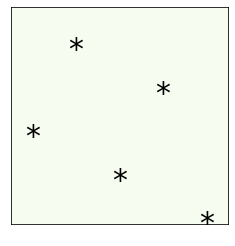

Satisfies constraints: True
Has lowest energy: True


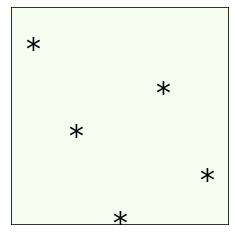

Satisfies constraints: True
Has lowest energy: True


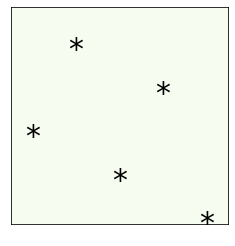

Satisfies constraints: True
Has lowest energy: True


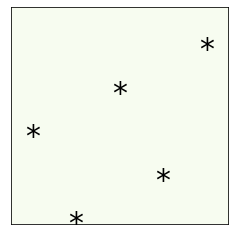

Satisfies constraints: True
Has lowest energy: True


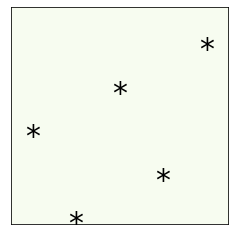

Satisfies constraints: True
Has lowest energy: True


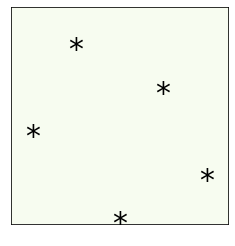

Satisfies constraints: True
Has lowest energy: True


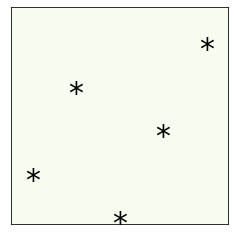

Satisfies constraints: True
Has lowest energy: True


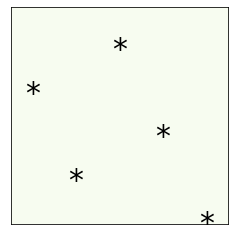

Satisfies constraints: True
Has lowest energy: True


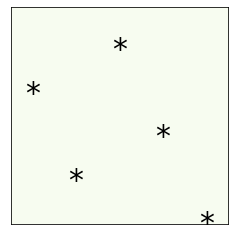

Satisfies constraints: True
Has lowest energy: True


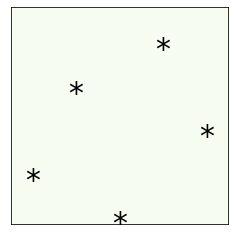

Satisfies constraints: True
Has lowest energy: True


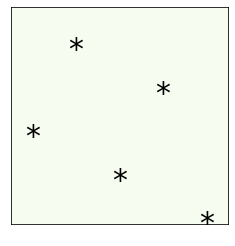

Satisfies constraints: True
Has lowest energy: True


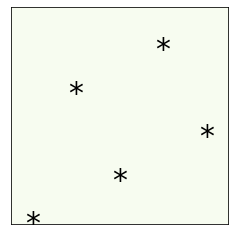

Satisfies constraints: True
Has lowest energy: True


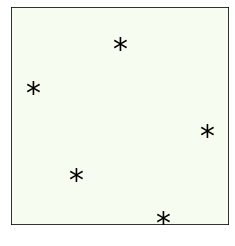

Satisfies constraints: True
Has lowest energy: True


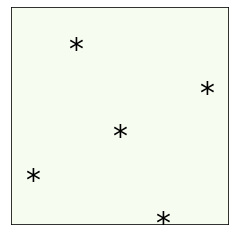

Satisfies constraints: True
Has lowest energy: True


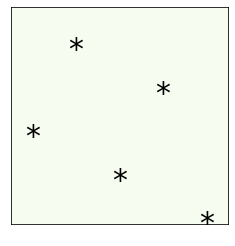

Satisfies constraints: True
Has lowest energy: True


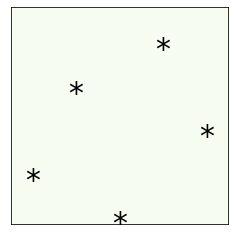

Satisfies constraints: True
Has lowest energy: True


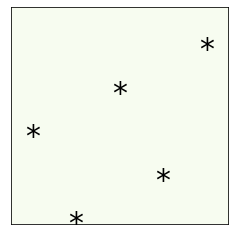

Satisfies constraints: True
Has lowest energy: True


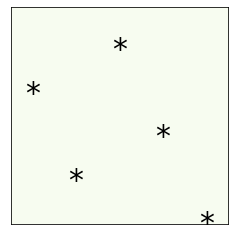

Satisfies constraints: True
Has lowest energy: True


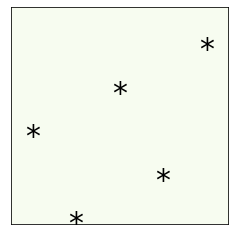

Satisfies constraints: True
Has lowest energy: True


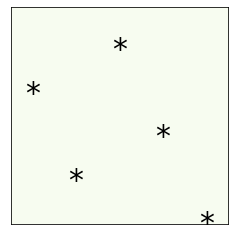

Satisfies constraints: True
Has lowest energy: True


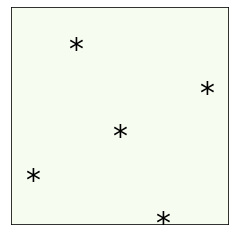

Satisfies constraints: True
Has lowest energy: True


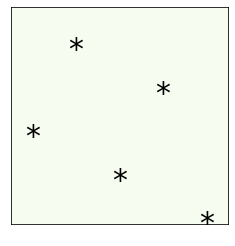

Satisfies constraints: True
Has lowest energy: True


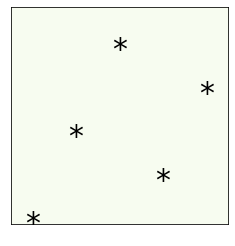

Satisfies constraints: True
Has lowest energy: True


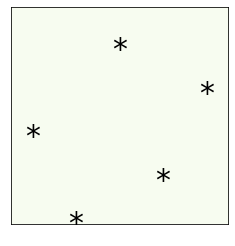

Satisfies constraints: True
Has lowest energy: True


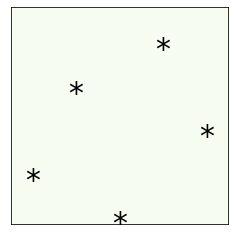

Satisfies constraints: True
Has lowest energy: True


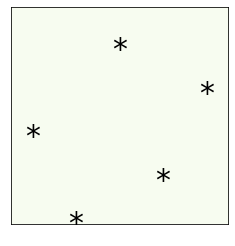

Satisfies constraints: True
Has lowest energy: True


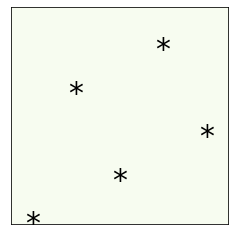

Satisfies constraints: True
Has lowest energy: True


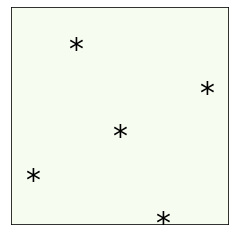

Satisfies constraints: True
Has lowest energy: True


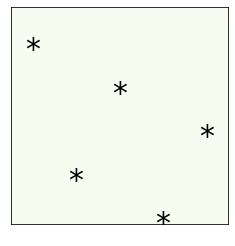

Satisfies constraints: True
Has lowest energy: True


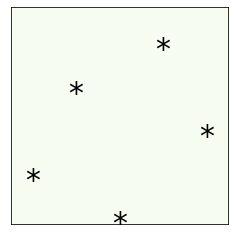

Satisfies constraints: True
Has lowest energy: True


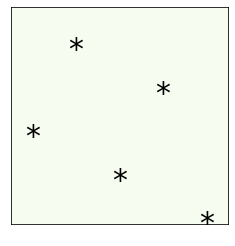

Satisfies constraints: True
Has lowest energy: True


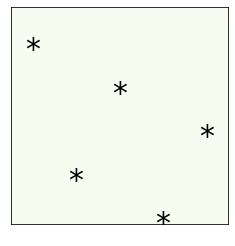

Satisfies constraints: True
Has lowest energy: True


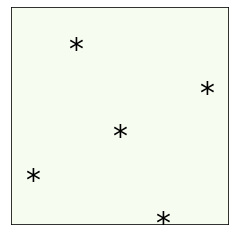

Satisfies constraints: True
Has lowest energy: True


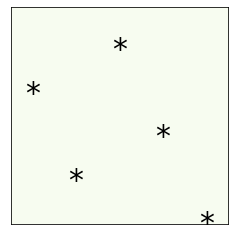

Satisfies constraints: True
Has lowest energy: True


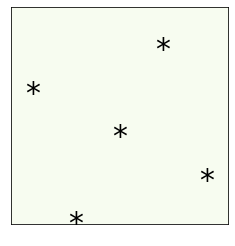

Satisfies constraints: True
Has lowest energy: True


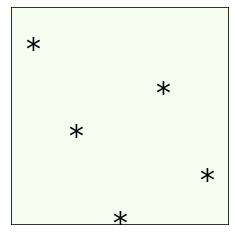

Satisfies constraints: True
Has lowest energy: True


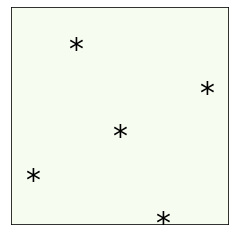

Satisfies constraints: True
Has lowest energy: True


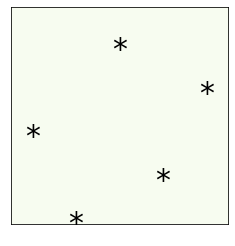

Satisfies constraints: True
Has lowest energy: True


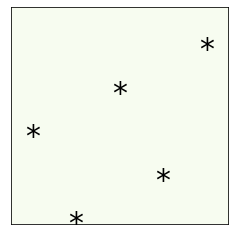

Satisfies constraints: True
Has lowest energy: True


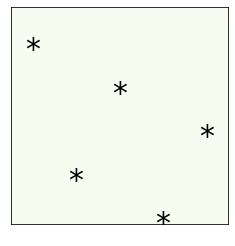

Satisfies constraints: True
Has lowest energy: True


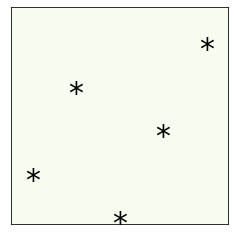

Satisfies constraints: True
Has lowest energy: True


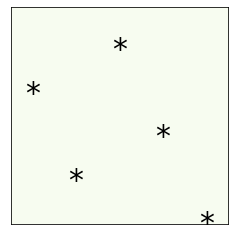

Satisfies constraints: True
Has lowest energy: True


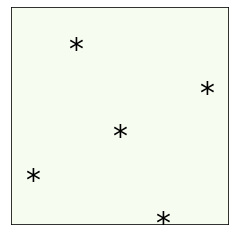

Satisfies constraints: True
Has lowest energy: True


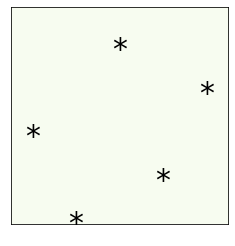

Satisfies constraints: True
Has lowest energy: True


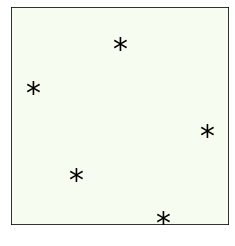

Satisfies constraints: True
Has lowest energy: True


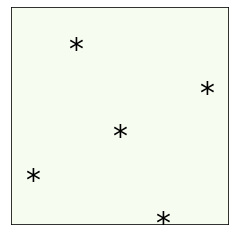

Satisfies constraints: True
Has lowest energy: True


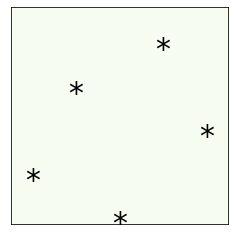

Satisfies constraints: True
Has lowest energy: True


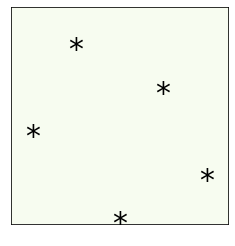

Satisfies constraints: True
Has lowest energy: True


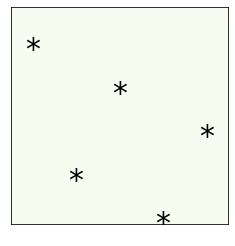

Satisfies constraints: True
Has lowest energy: True


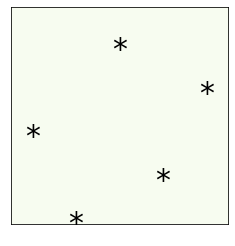

Satisfies constraints: True
Has lowest energy: True


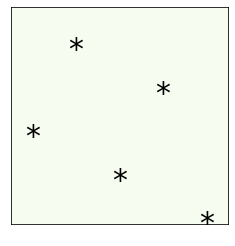

Satisfies constraints: True
Has lowest energy: True


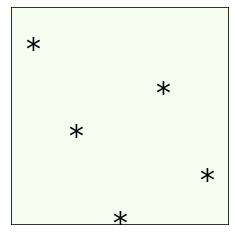

Satisfies constraints: True
Has lowest energy: True


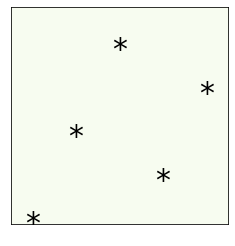

Satisfies constraints: True
Has lowest energy: True


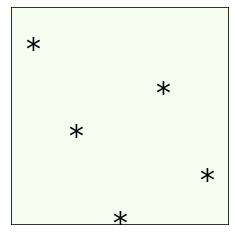

Satisfies constraints: True
Has lowest energy: True


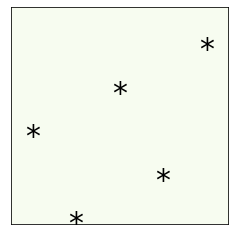

Satisfies constraints: True
Has lowest energy: True


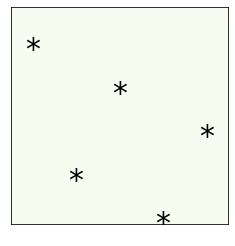

Satisfies constraints: True
Has lowest energy: True


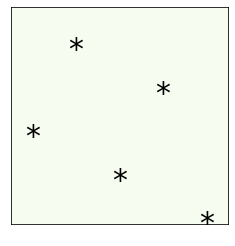

Satisfies constraints: True
Has lowest energy: True


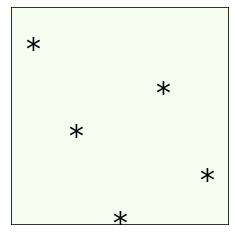

Satisfies constraints: True
Has lowest energy: True


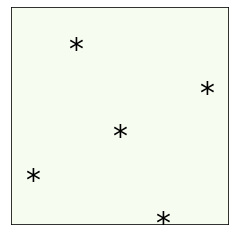

Satisfies constraints: True
Has lowest energy: True


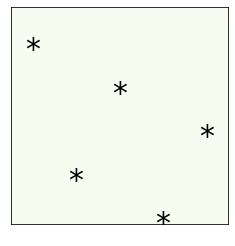

Satisfies constraints: True
Has lowest energy: True


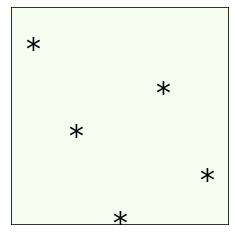

Satisfies constraints: True
Has lowest energy: True


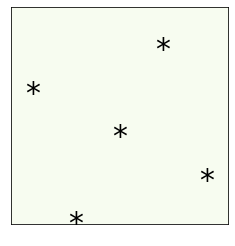

Satisfies constraints: True
Has lowest energy: True


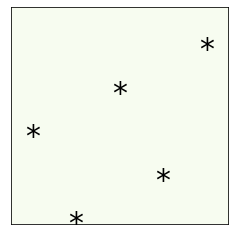

Satisfies constraints: True
Has lowest energy: True


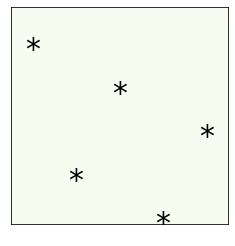

Satisfies constraints: True
Has lowest energy: True


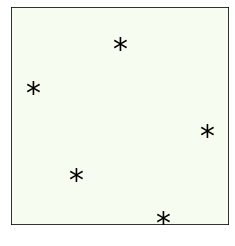

Satisfies constraints: True
Has lowest energy: True


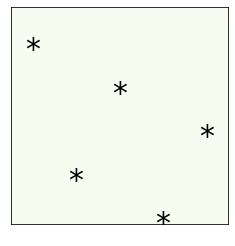

Satisfies constraints: True
Has lowest energy: True


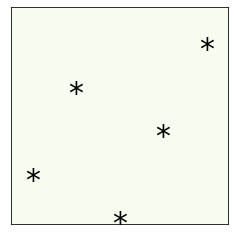

Satisfies constraints: True
Has lowest energy: True


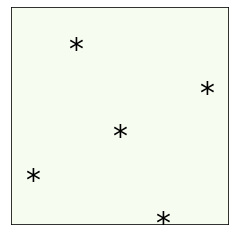

Satisfies constraints: True
Has lowest energy: True


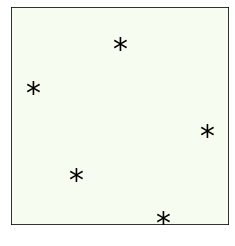

Satisfies constraints: True
Has lowest energy: True


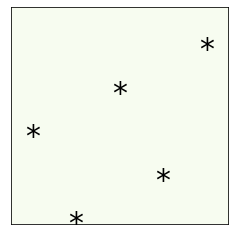

Satisfies constraints: True
Has lowest energy: True


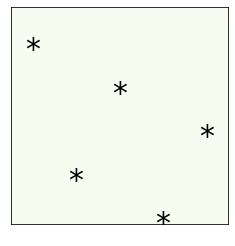

Satisfies constraints: True
Has lowest energy: True


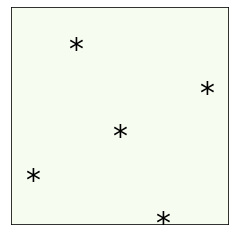

Satisfies constraints: True
Has lowest energy: True


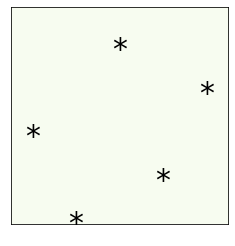

Satisfies constraints: True
Has lowest energy: True


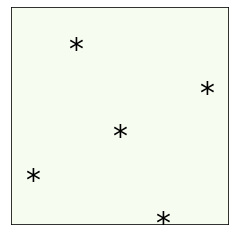

Satisfies constraints: True
Has lowest energy: True


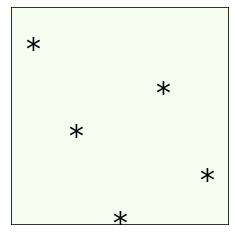

Satisfies constraints: True
Has lowest energy: True


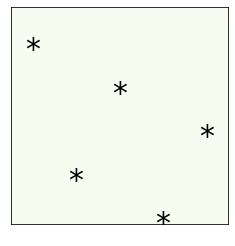

Satisfies constraints: True
Has lowest energy: True


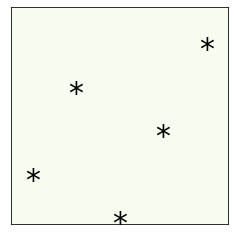

Satisfies constraints: True
Has lowest energy: True


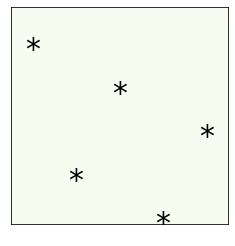

Satisfies constraints: True
Has lowest energy: True


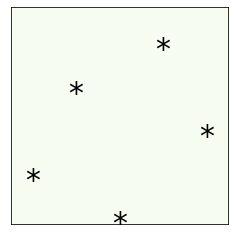

Satisfies constraints: True
Has lowest energy: True


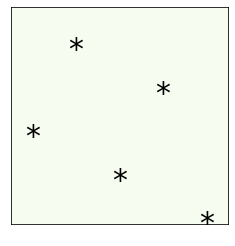

Satisfies constraints: True
Has lowest energy: True


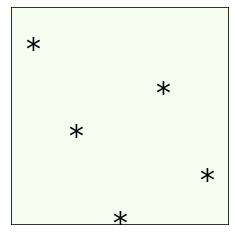

Satisfies constraints: True
Has lowest energy: True


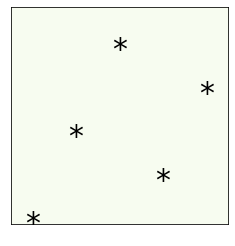

Satisfies constraints: True
Has lowest energy: True


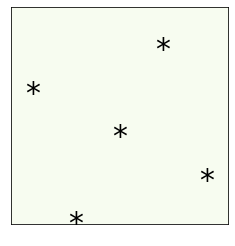

Satisfies constraints: True
Has lowest energy: True


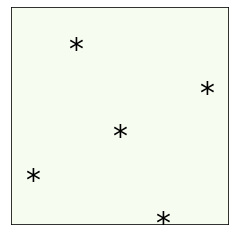

Satisfies constraints: True
Has lowest energy: True


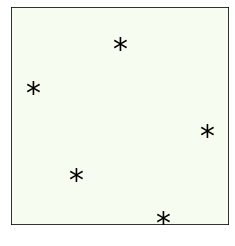

Satisfies constraints: True
Has lowest energy: True


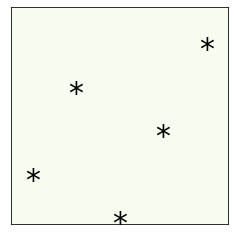

Satisfies constraints: True
Has lowest energy: True


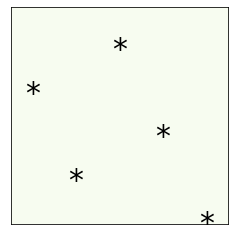

Satisfies constraints: True
Has lowest energy: True


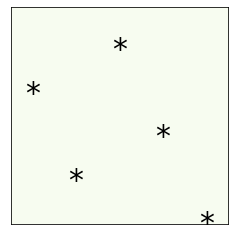

Satisfies constraints: True
Has lowest energy: True


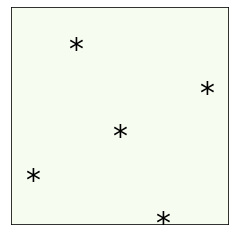

Satisfies constraints: True
Has lowest energy: True


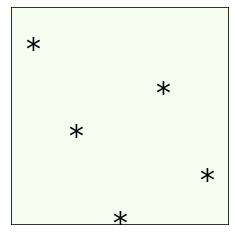

Satisfies constraints: True
Has lowest energy: True


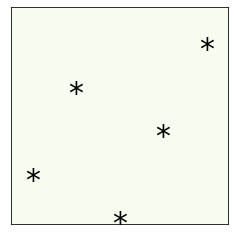

Satisfies constraints: True
Has lowest energy: True


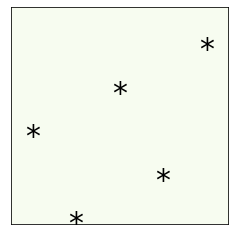

Satisfies constraints: True
Has lowest energy: True


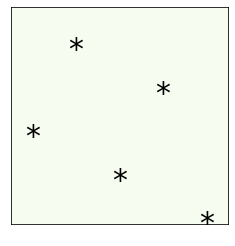

Satisfies constraints: True
Has lowest energy: True


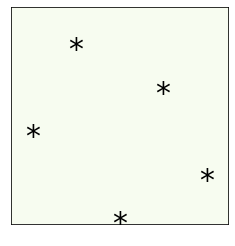

Satisfies constraints: True
Has lowest energy: True


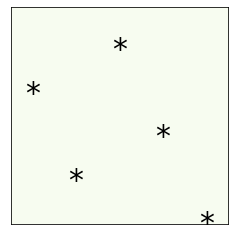

Satisfies constraints: True
Has lowest energy: True


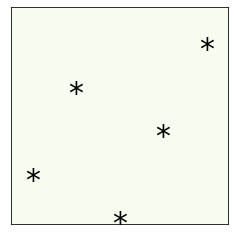

Satisfies constraints: True
Has lowest energy: True


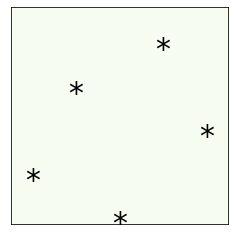

Satisfies constraints: True
Has lowest energy: True


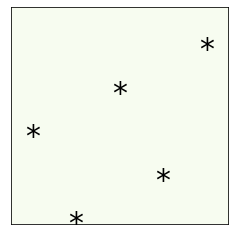

Satisfies constraints: True
Has lowest energy: True


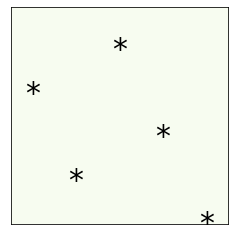

Satisfies constraints: True
Has lowest energy: True


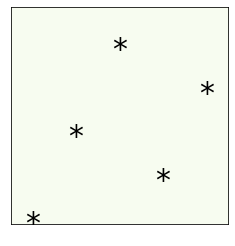

In [87]:
# sampleset = LEAPsampleset
sorted_records = sorted(sampleset.record, key=lambda r: r.energy)
variables = sampleset.variables
for record in sorted_records:
    sample = {x_ij: value for x_ij, value in zip(variables, record.sample)}
    energy = record.energy
    # if energy < -402:
    cond_1 = confirm_solution(sample, regions, nstars)
    cond_2 = abs(energy-minimum_theo) < 1e-6
    print('Satisfies constraints:', cond_1)
    print('Has lowest energy:', cond_2)
    sample_to_plot(sample)
    if not cond_1 | cond_2:
        break

In [86]:
def get_star_positions(sampleset, n):
    sorted_records = sorted(sampleset.record, key=lambda r: r.energy)
    variables = sampleset.variables
    record = sorted_records[n]
    sample = {x_ij: value for x_ij, value in zip(variables, record.sample)}
    energy = record.energy
    cond_1 = confirm_solution(sample, regions, nstars)
    cond_2 = abs(energy-minimum_theo) < 1e-6
    print('Satisfies constraints:', cond_1)
    print('Has lowest energy:', cond_2)
    stars, solution = star_solutions(sample)
    return stars

In [88]:
star_positions, solution = get_star_positions(sampleset, 0)

Satisfies constraints: True
Has lowest energy: True


In [96]:
# Build Star Finder QUBO
g1, g2, g3 = 1, 1, 1
Q_reg_1 = g1*constraint_sum_of_stars(N, nstars, star_positions)
Q_reg_2 = g2*constraint_unique_color(N)
Q_reg_3 = g3*constraint_contiguous(N)
Q_reg = Q_reg_1+Q_reg_2+Q_reg_3

In [100]:
sampler2 = neal.SimulatedAnnealingSampler()
sampleset2 = sampler2.sample_qubo(Q_reg, num_reads=100)
#sampleset = LEAPsampleset
minimum_theo_2 = -g1*N*nstars**2 -g2*N**2 
print('Theory:', minimum_theo_2)
print(sampleset2)

Theory: -30
   x0_0_0 x0_0_1 x0_0_2 x0_0_3 x0_0_4 x0_1_0 x0_1_1 ... x4_4_4 energy num_oc.
0       1      0      0      0      0      0      0 ...      1  -60.0       1
1       1      0      0      0      0      0      0 ...      0  -60.0       1
2       1      0      0      0      0      0      0 ...      0  -60.0       1
3       1      0      0      0      0      0      1 ...      1  -60.0       1
4       1      0      0      0      0      0      0 ...      0  -60.0       1
5       1      0      0      0      0      0      0 ...      0  -60.0       1
6       1      0      0      0      0      0      0 ...      0  -60.0       1
7       1      0      0      0      0      0      1 ...      0  -60.0       1
8       1      0      0      0      0      0      0 ...      0  -60.0       1
9       1      0      0      0      0      0      1 ...      0  -60.0       1
10      1      0      0      0      0      0      0 ...      0  -60.0       1
11      1      0      0      0      0      0      1 

In [ ]:
# sampleset = LEAPsampleset
sorted_records2 = sorted(sampleset2.record, key=lambda r: r.energy)
variables2 = sampleset2.variables
for record2 in sorted_records2:
    sample = {x_ij: value for x_ij, value in zip(variables2, record2.sample)}
    energy = record.energy
    # if energy < -402:
    cond_1 = confirm_solution(sample, regions, nstars)
    #cond_2 = abs(energy-minimum_theo) < 1e-6
    print('Satisfies constraints:', cond_1)
    print('Has lowest energy:', cond_2)
    sample_to_plot(sample)
    if not cond_1:
        break